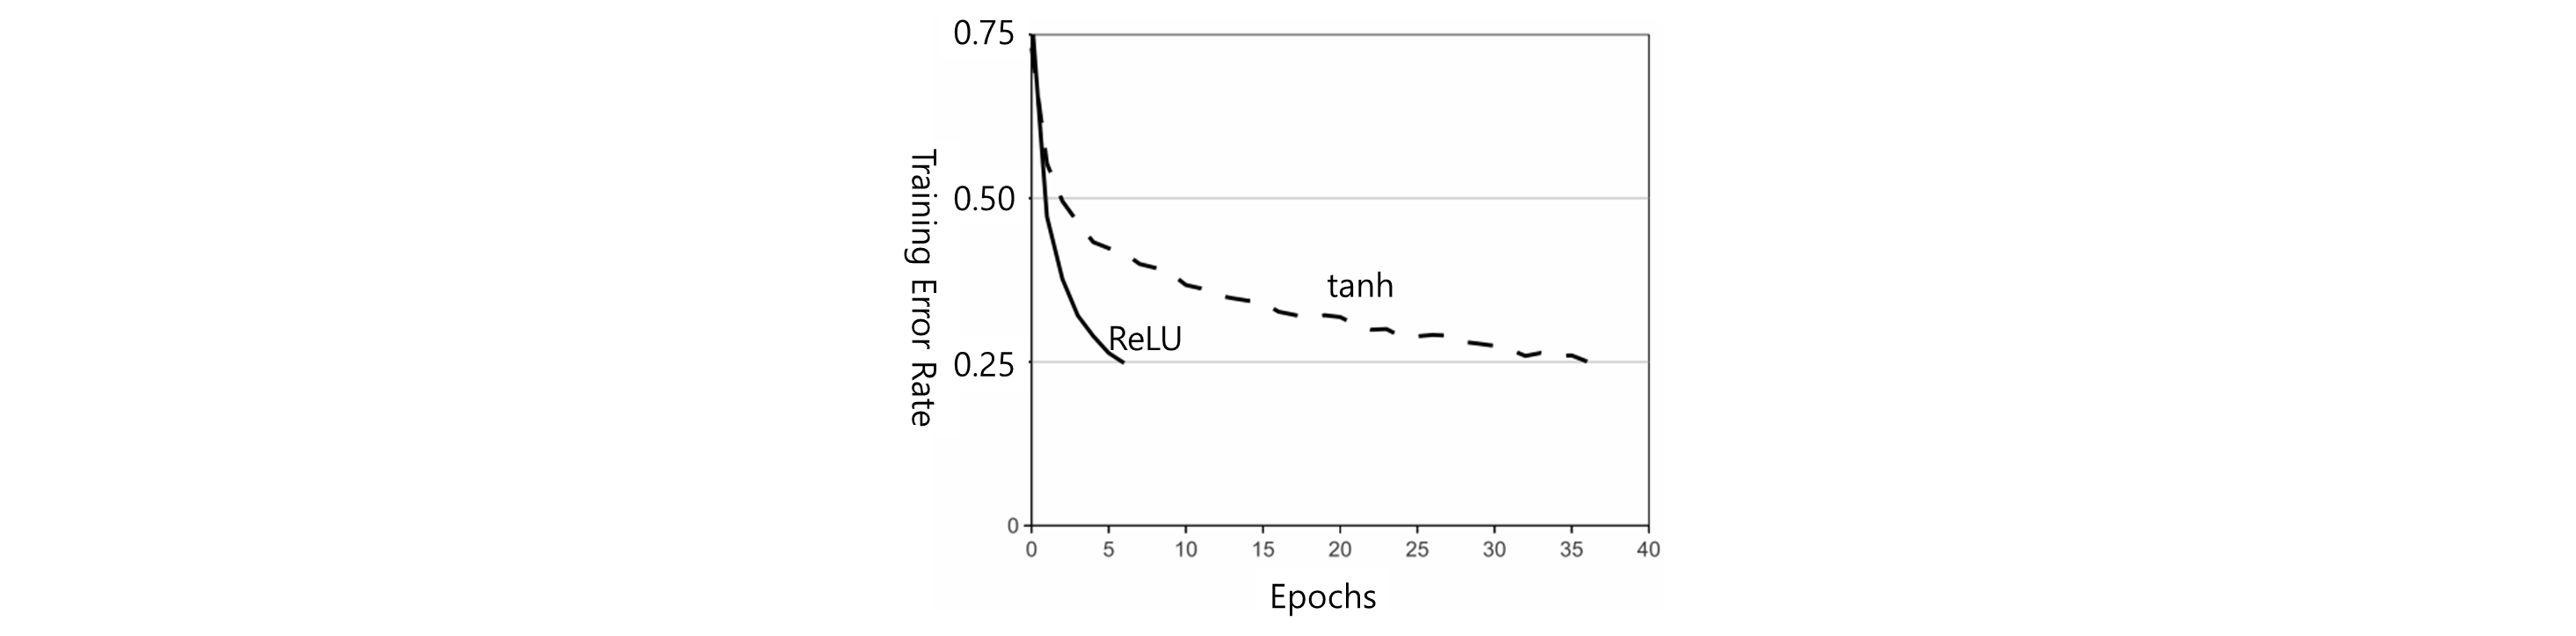

#### **Overlapping Max$-$Pooling을 사용**

- 일반적인 Max$-$Pooling 방법은 Image의 특성을 유지하면서 Image의 Size를 줄이는 방법으로 사용되는  것에 비해 <br> AlexNet에서의 Max$-$Pooling 방법은 다음과 같음

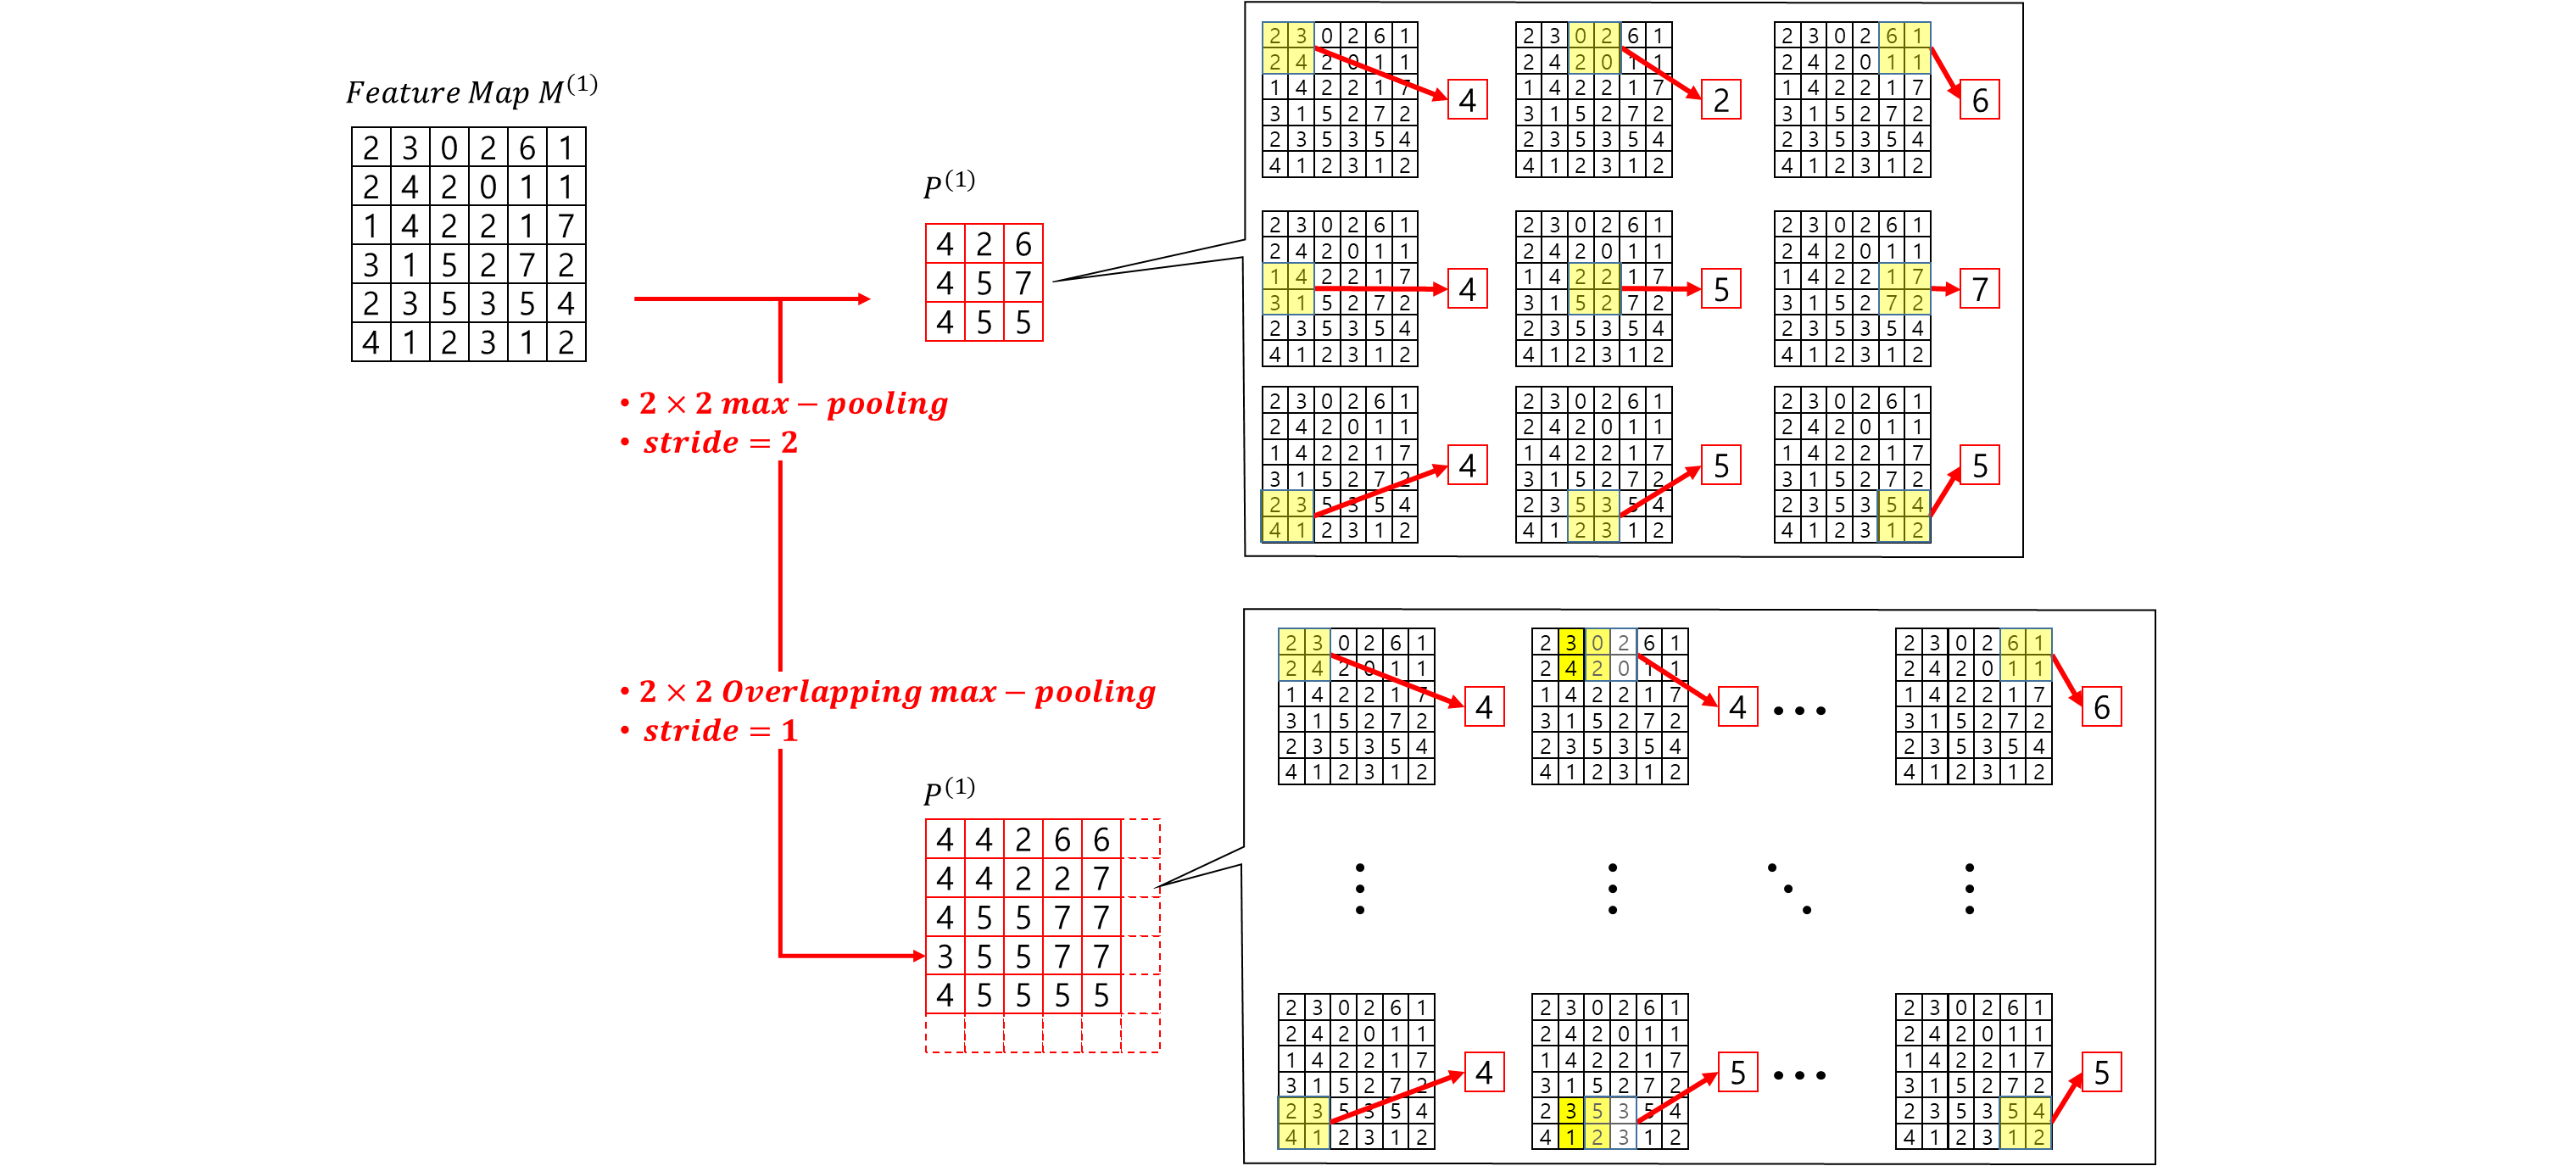

In [1]:
import keras
from tensorflow.keras.layers import Input
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import ELU, PReLU, LeakyReLU

import tensorflow as tf
from tensorflow import keras
import keras.layers as layers

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [4]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [7]:
train_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.uint8, name=None))>

#### **Preprocessing**

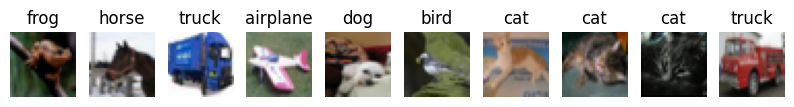

In [8]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_ds.take(10)):
    ax = plt.subplot(10,10,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

- AlexNet network의  Input은 $227 \times 227$ Image임
- $ cifar10\    32 \times 32$ Input Image를  $227 \times 227$로 Resize

In [9]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label

In [10]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 45000
Test data size: 10000
Validation data size: 5000


In [11]:
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

In [12]:
print(train_ds)

<_BatchDataset element_spec=(TensorSpec(shape=(32, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 1), dtype=tf.uint8, name=None))>


#### **Model**

In [20]:
model = keras.models.Sequential([
    Input(shape=(227, 227, 3)),
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(10, activation='softmax')
])

#### **TensorBoard**
- TensorBoard is a tool that provides a suite of visualization and monitoring mechanisms

In [21]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 55, 55, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │              

 Total params: 58,327,818 (222.50 MB)

 Trainable params: 58,325,066 (222.49 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [15]:
model.fit(train_ds,
          epochs = 1,  ## Computing Time 매우 김
          validation_data=validation_ds)

1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1007s 713ms/step - accuracy: 0.3448 - loss: 2.0653 - val_accuracy: 0.5274 - val_loss: 1.3558


#### **Evaluation**

In [16]:
model.evaluate(test_ds)

312/312 ━━━━━━━━━━━━━━━━━━━━ 72s 228ms/step - accuracy: 0.5058 - loss: 1.3782


[1.3782093524932861, 0.5058093070983887]